In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import fiona

print("Loaded libraries successfully.")

Loaded libraries successfully.


In [ ]:
# take in paths for files (gedi and prodes)
# NOTE: geojson for Para taken from: https://github.com/giuliano-macedo/geodata-br-states/blob/main/geojson/br_states/br_pa.json?short_path=3db5bcb
# geojson is used to get the gedi data only for Para state in VegMapper/gedi/gedi_l2a_arset.ipynb

# NOTE: PRODES data taken from: https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/2ffd2efa-31a5-451b-9b8f-cbd2f6c1ae83
gedi = input("Enter path to GEDI file (.csv): ")
prodes = input("Enter path to PRODES file (.gpkg): ")

lat_col, lon_col = 'latitude', 'longitude'  # specify the column names for latitude and longitude

gedi_df = pd.read_csv(gedi)
prodes_df = gpd.read_file(prodes)

/Users/akshatk/miniconda3/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'prodes_amazonia_legal.gpkg': 'accumulated_deforestation_2007' (default), 'hydrography', 'yearly_deforestation', 'no_forest', 'residual'. Specify layer parameter to avoid this warning.
  result = read_func(


In [6]:
# geopandas doesn't load all layers by default, so we need to read each layer and concatenate 🤦‍♂️

layers = fiona.listlayers(prodes)
print(f"Available layers in GPKG: {layers}")

all_prodes_layers = []
for layer in layers:
    print(f"Reading layer: {layer}")
    layer_gdf = gpd.read_file(prodes, layer=layer)
    layer_gdf['layer_source'] = layer  # add a column to identify the source
    all_prodes_layers.append(layer_gdf)

prodes_df = gpd.GeoDataFrame(pd.concat(all_prodes_layers, ignore_index=True))
print(f"Main class values: {prodes_df['main_class'].unique()}")

Available layers in GPKG: ['accumulated_deforestation_2007', 'hydrography', 'yearly_deforestation', 'no_forest', 'residual']
Reading layer: accumulated_deforestation_2007
Reading layer: hydrography
Reading layer: yearly_deforestation
Reading layer: no_forest
Reading layer: residual
Main class values: ['DESMATAMENTO' 'HIDROGRAFIA' 'NAO_FLORESTA' 'RESIDUO']


In [10]:
# print all states in prodes_df
print("States in PRODES data:", prodes_df['state'].unique()) 

# get number of rows for each state
state_counts = prodes_df['state'].value_counts()
print("Number of rows for each state in PRODES data:\n", state_counts)

# chose "AC" (Acre) as state to test histograms on since it had 24k rows of data
acre_prodes = prodes_df[prodes_df['state'] == 'AC']

States in PRODES data: ['RR' 'PA' 'AM' 'MA' 'MT' 'TO' 'AC' 'RO' 'AP' 'MS']
Number of rows for each state in PRODES data:
 state
PA    480247
AM    165529
MT    134322
AC    103564
RO    102472
MA     81719
RR     53108
AP     19078
TO      9986
MS         2
Name: count, dtype: int64


In [12]:
for layer in layers:
    print(f"\nReading '{layer}':")
    with fiona.open(prodes, layer=layer) as lyr:
        print(lyr.schema)
        print(f"CRS is: {lyr.crs}")


Reading 'accumulated_deforestation_2007':
{'properties': {'state': 'str:99', 'path_row': 'str:20', 'main_class': 'str:255', 'class_name': 'str:255', 'def_cloud': 'float', 'julian_day': 'int32', 'image_date': 'date', 'year': 'float', 'area_km': 'float', 'scene_id': 'int32', 'source': 'str:50', 'satellite': 'str:50', 'sensor': 'str:50', 'uuid': 'str'}, 'geometry': 'Unknown'}
CRS is: EPSG:4674

Reading 'hydrography':
{'properties': {'state': 'str:99', 'path_row': 'str:20', 'main_class': 'str:255', 'class_name': 'str:255', 'def_cloud': 'float', 'julian_day': 'int32', 'image_date': 'date', 'year': 'float', 'area_km': 'float', 'scene_id': 'int32', 'source': 'str:50', 'satellite': 'str:50', 'sensor': 'str:50', 'uuid': 'str'}, 'geometry': 'Unknown'}
CRS is: EPSG:4674

Reading 'yearly_deforestation':
{'properties': {'state': 'str:99', 'path_row': 'str:20', 'main_class': 'str:255', 'class_name': 'str:255', 'sub_class': 'str:255', 'def_cloud': 'float', 'julian_day': 'int32', 'image_date': 'date'

In [13]:
# Convert GEDI points into GeoDataFrame for spatial operations
gedi_gdf = gpd.GeoDataFrame(
    data = gedi_df,
    geometry = gpd.points_from_xy(gedi_df.longitude, gedi_df.latitude),
    crs = "EPSG:4674"  # CHANGE THIS BASED ON GEDI DATA CRS (above)
)

# Ensure both GeoDataFrames use the same CRS
if gedi_gdf.crs != acre_prodes.crs:
    print(f"The CRS of the GEDI data {gedi_gdf.crs} does not match the PRODES data CRS {acre_prodes.crs}")
    gedi_gdf = gedi_gdf.to_crs(acre_prodes.crs)
    print(f"Transformed GEDI data to CRS of PRODES data: {gedi_gdf.crs}")


In [14]:
# First few rows of new gedi GeoDataFrame (converted from CSV)
gedi_gdf.head()

,source_url,beam,shot_number,latitude,longitude,rh25,rh50,rh75,rh95,sensitivity,solar_elevation,geometry
0,https://harmony.earthdata.nasa.gov/service-res...,BEAM0101,338350500100046529,-7.443723,-73.928047,10.03,19.99,22.31,24.78,0.972721,35.823444,POINT (-73.92805 -7.44372)
1,https://harmony.earthdata.nasa.gov/service-res...,BEAM0101,338350500100046530,-7.443301,-73.927743,13.25,20.02,23.02,25.98,0.978348,35.823600,POINT (-73.92774 -7.4433)
2,https://harmony.earthdata.nasa.gov/service-res...,BEAM0101,338350500100046531,-7.442881,-73.927440,4.26,9.06,14.52,20.47,0.973001,35.823753,POINT (-73.92744 -7.44288)
3,https://harmony.earthdata.nasa.gov/service-res...,BEAM0101,338350500100046532,-7.442461,-73.927137,6.70,10.48,19.31,30.69,0.976818,35.823906,POINT (-73.92714 -7.44246)
4,https://harmony.earthdata.nasa.gov/service-res...,BEAM0101,338350500100046533,-7.442040,-73.926834,6.40,13.02,17.25,26.01,0.946995,35.824060,POINT (-73.92683 -7.44204)


In [15]:
# First few rows of Acre PRODES data
acre_prodes.head()

,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry,layer_source,sub_class
46,AC,00566,DESMATAMENTO,d2007,0.0,0.0,NaT,2007.0,0.000057,0.0,None,None,None,f5b6c3f0-c713-418f-969c-3d82ad96747f,"MULTIPOLYGON (((-72.40155 -8.94368, -72.40151 ...",accumulated_deforestation_2007,NaN
64,AC,00665,DESMATAMENTO,d2007,0.0,0.0,NaT,2007.0,23.322735,0.0,None,None,None,77f4d1db-27d3-49c6-9d74-0e65d2274766,"MULTIPOLYGON (((-73.63409 -7.46974, -73.63409 ...",accumulated_deforestation_2007,NaN
104,AC,00267,DESMATAMENTO,d2007,0.0,0.0,NaT,2007.0,0.000092,0.0,None,None,None,060e7351-5b30-433c-988d-18ffa3a52032,"MULTIPOLYGON (((-68.43083 -9.49863, -68.4308 -...",accumulated_deforestation_2007,NaN
107,AC,00466,DESMATAMENTO,d2007,0.0,0.0,NaT,2007.0,0.007055,0.0,None,None,None,2f40356d-3bf6-4c88-9d0e-0b3f5408361c,"MULTIPOLYGON (((-70.89457 -8.19909, -70.89457 ...",accumulated_deforestation_2007,NaN
108,AC,00566,DESMATAMENTO,d2007,0.0,0.0,NaT,2007.0,0.000639,0.0,None,None,None,8174cbea-5625-47ce-92a8-06fda7e9e2ef,"MULTIPOLYGON (((-72.74963 -8.30158, -72.74963 ...",accumulated_deforestation_2007,NaN


In [16]:
# Match GEDI points to PRODES polygons
matched_gdf = acre_prodes.sjoin(
    gedi_gdf,
    how="inner",
    predicate="contains" # checks that the prodes polygon contains the gedi point in it
)

In [17]:
# Get some statistics
print("Total number of GEDI points in Acre:", len(gedi_gdf))
print("Total number of PRODES polygons in Acre:", len(acre_prodes))
print("Total number of matched pairs (aka rows in matched_gdf):", len(matched_gdf))
print("The different land cover types in matched dataset: ", matched_gdf['main_class'].unique())
print(f"Columns in the matched dataset: \n{matched_gdf.columns.tolist()}")

Total number of GEDI points in Acre: 118491
Total number of PRODES polygons in Acre: 103564
Total number of matched pairs (aka rows in matched_gdf): 8584
The different land cover types in matched dataset:  ['DESMATAMENTO' 'HIDROGRAFIA' 'NAO_FLORESTA' 'RESIDUO']
Columns in the matched dataset: 
['state', 'path_row', 'main_class', 'class_name', 'def_cloud', 'julian_day', 'image_date', 'year', 'area_km', 'scene_id', 'source', 'satellite', 'sensor', 'uuid', 'geometry', 'layer_source', 'sub_class', 'index_right', 'source_url', 'beam', 'shot_number', 'latitude', 'longitude', 'rh25', 'rh50', 'rh75', 'rh95', 'sensitivity', 'solar_elevation']


In [23]:
# For each column print its name and the unique values
for col in matched_gdf.columns:
    unique_vals = matched_gdf[col].unique()
    print(f"Column '{col}' has {len(unique_vals)} unique values: {unique_vals if len(unique_vals) < 10 else unique_vals[:10]} \n")

Column 'state' has 1 unique values: ['AC'] 

Column 'path_row' has 24 unique values: ['00267' '00366' '00367' '00268' '00466' '00565' '00465' '00566' '00167'
 '00266'] 

Column 'main_class' has 4 unique values: ['DESMATAMENTO' 'HIDROGRAFIA' 'NAO_FLORESTA' 'RESIDUO'] 

Column 'class_name' has 32 unique values: ['d2007' 'HIDROGRAFIA' 'd2024' 'd2022' 'd2023' 'd2014' 'd2016' 'd2018'
 'd2013' 'd2011'] 

Column 'def_cloud' has 6 unique values: [   0.   nan 2011. 2009. 2020. 2018.] 

Column 'julian_day' has 59 unique values: [  0. 209. 211. 242. 229. 230. 236. 212. 235. 202.] 

Column 'image_date' has 116 unique values: <DatetimeArray>
[                'NaT', '2024-07-27 00:00:00', '2024-07-29 00:00:00',
 '2022-08-30 00:00:00', '2022-08-17 00:00:00', '2023-08-18 00:00:00',
 '2022-08-24 00:00:00', '2022-07-31 00:00:00', '2022-08-23 00:00:00',
 '2022-07-21 00:00:00']
Length: 10, dtype: datetime64[ms] 

Column 'year' has 18 unique values: [2007. 2024. 2022. 2023. 2014. 2016. 2018. 2013. 2011. 20

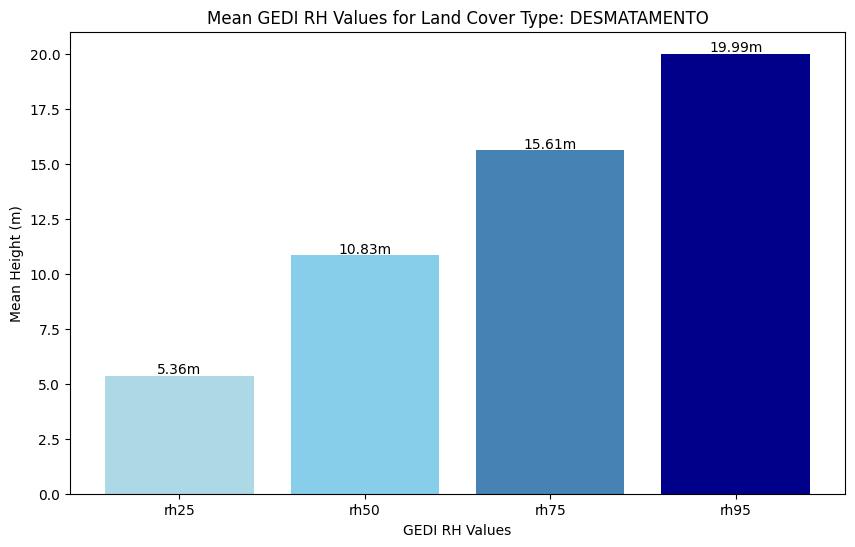

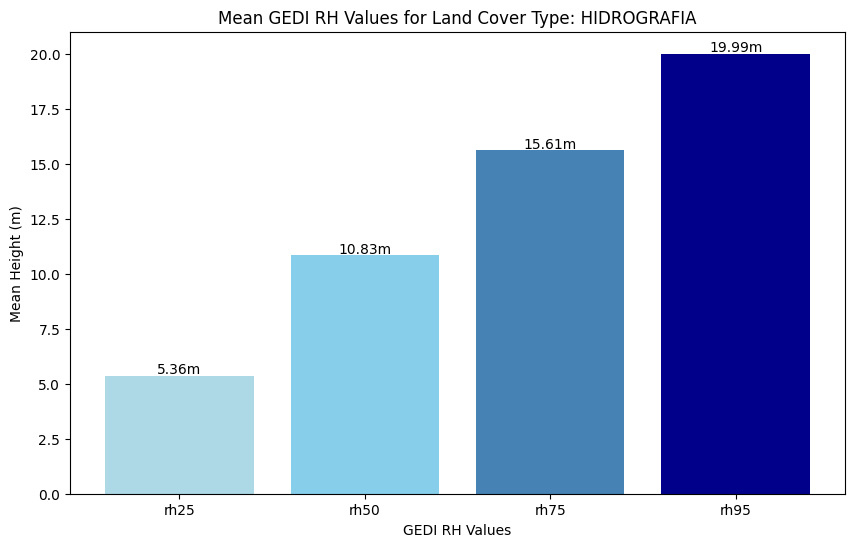

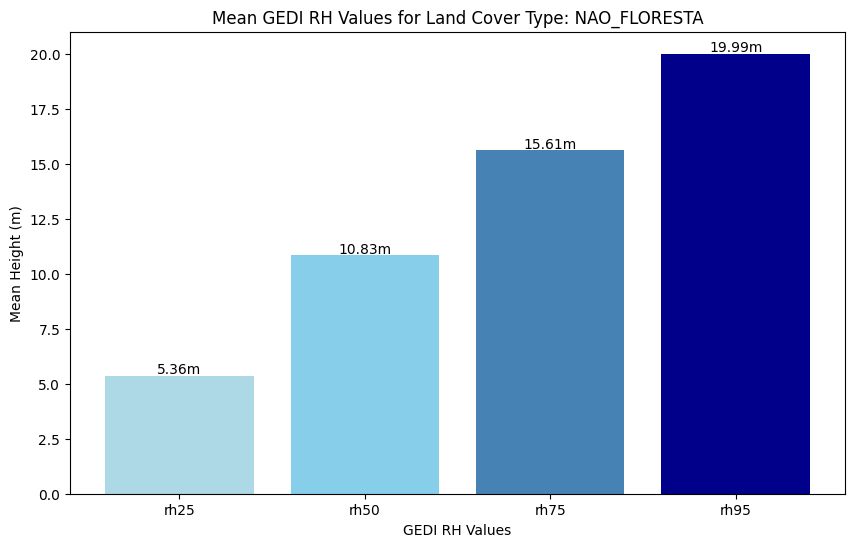

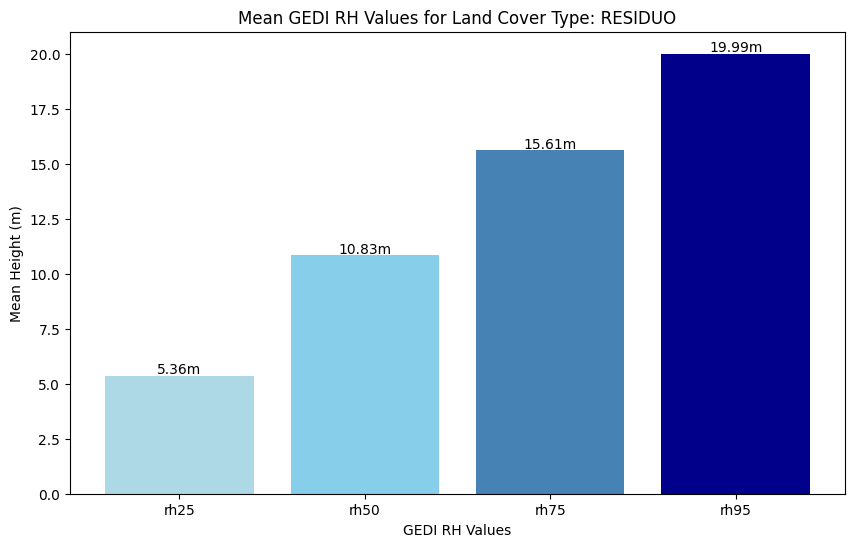

In [ ]:
# Create barchart of avg rh values based on land cover type
land_types = matched_gdf['main_class'].unique()

for land_type in land_types:
    barplot_data = matched_gdf[matched_gdf['main_class'] == land_type]

    rh_values = ['rh25', 'rh50', 'rh75', 'rh95']
    mean_values = []
    for val in rh_values:
        mean_values.append(barplot_data[val].dropna().mean())
    
    plt.figure(figsize=(10, 6))
    plt.bar(x = rh_values, height = mean_values, color=['lightblue', 'skyblue', 'steelblue', 'darkblue'])

    for i, mean_val in enumerate(mean_values):
        plt.text(i, mean_val + 0.1, f'{mean_val:.2f}m', ha='center')

    plt.xlabel('GEDI RH Values')
    plt.ylabel('Mean Height (m)')
    plt.title(f'Mean GEDI RH Values for Land Cover Type: {land_type}')
    
    plt.show()

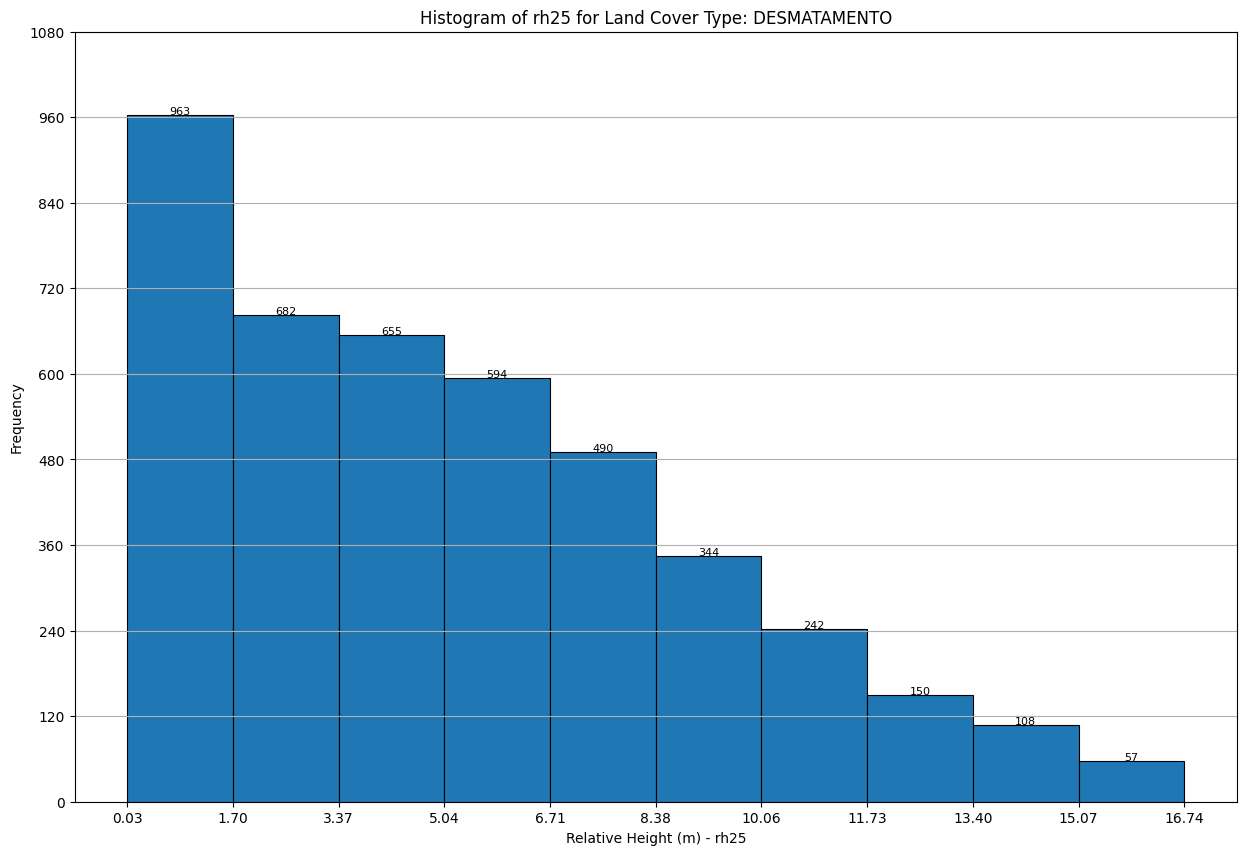

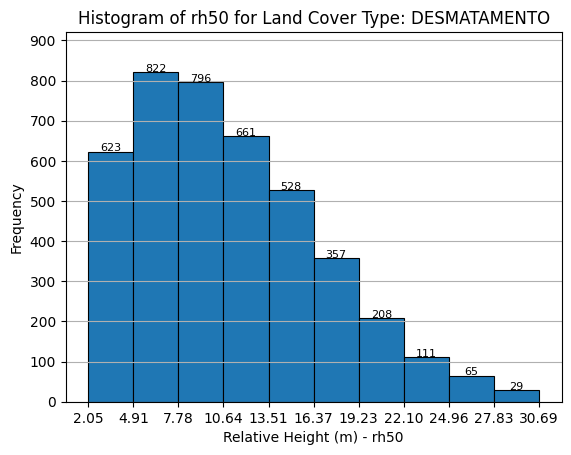

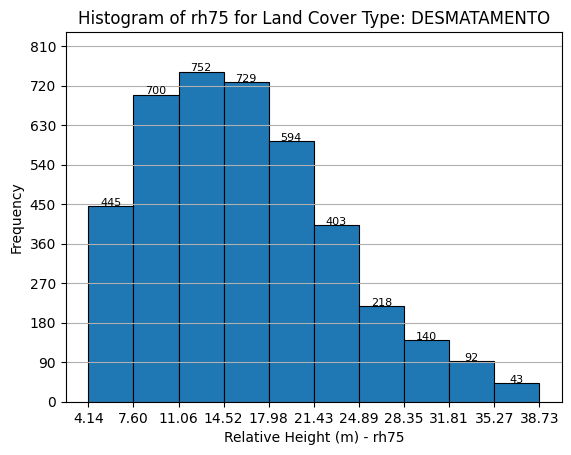

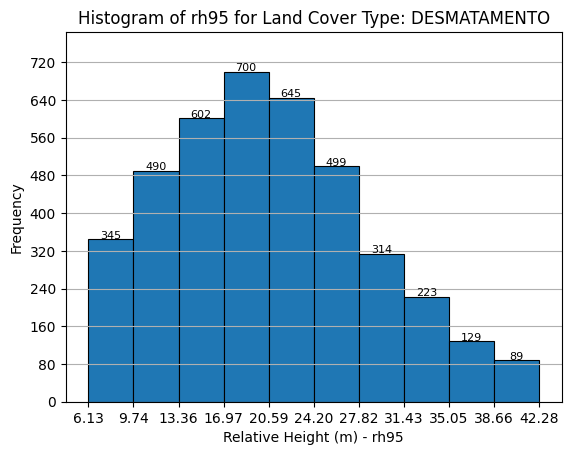

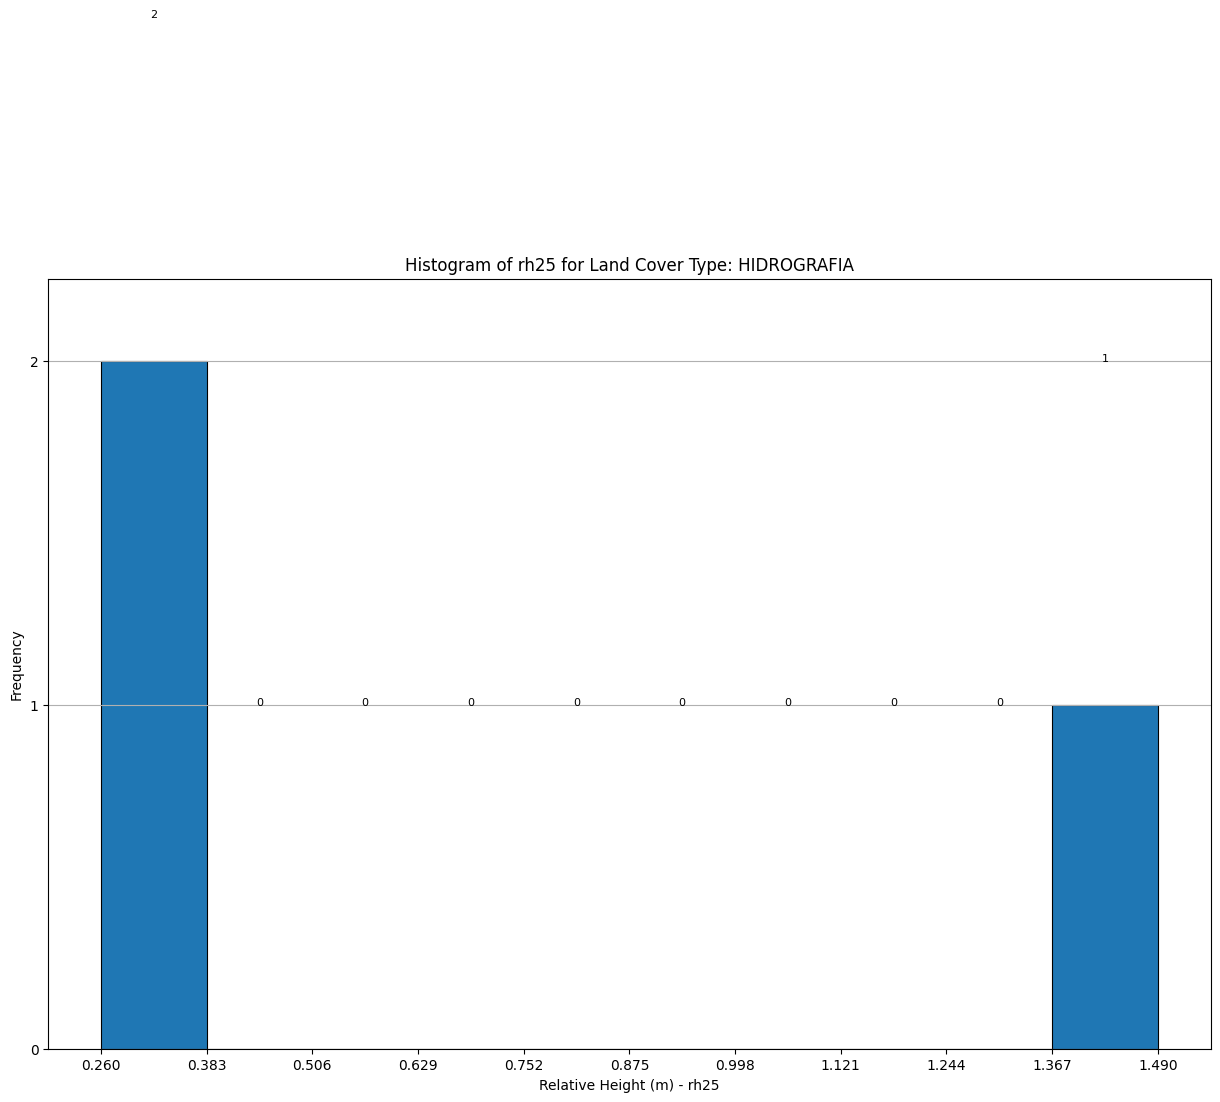

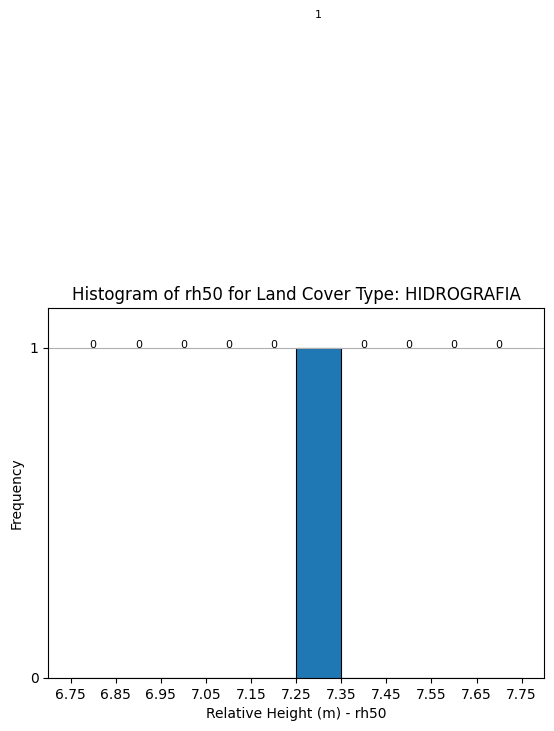

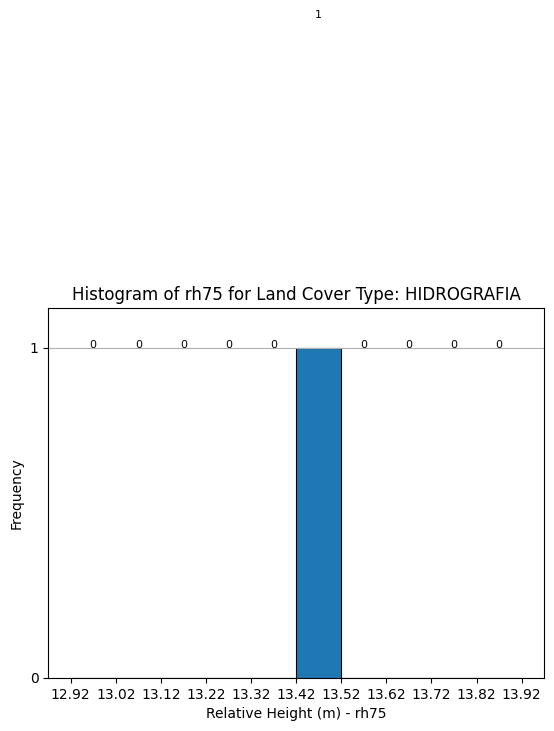

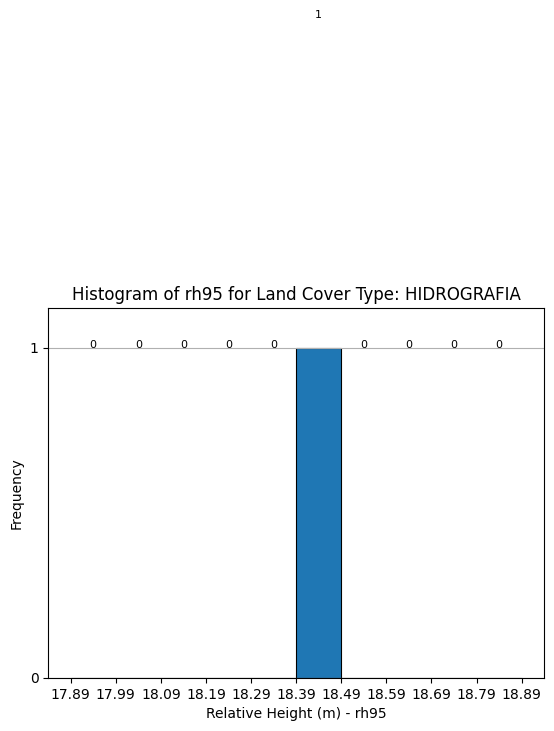

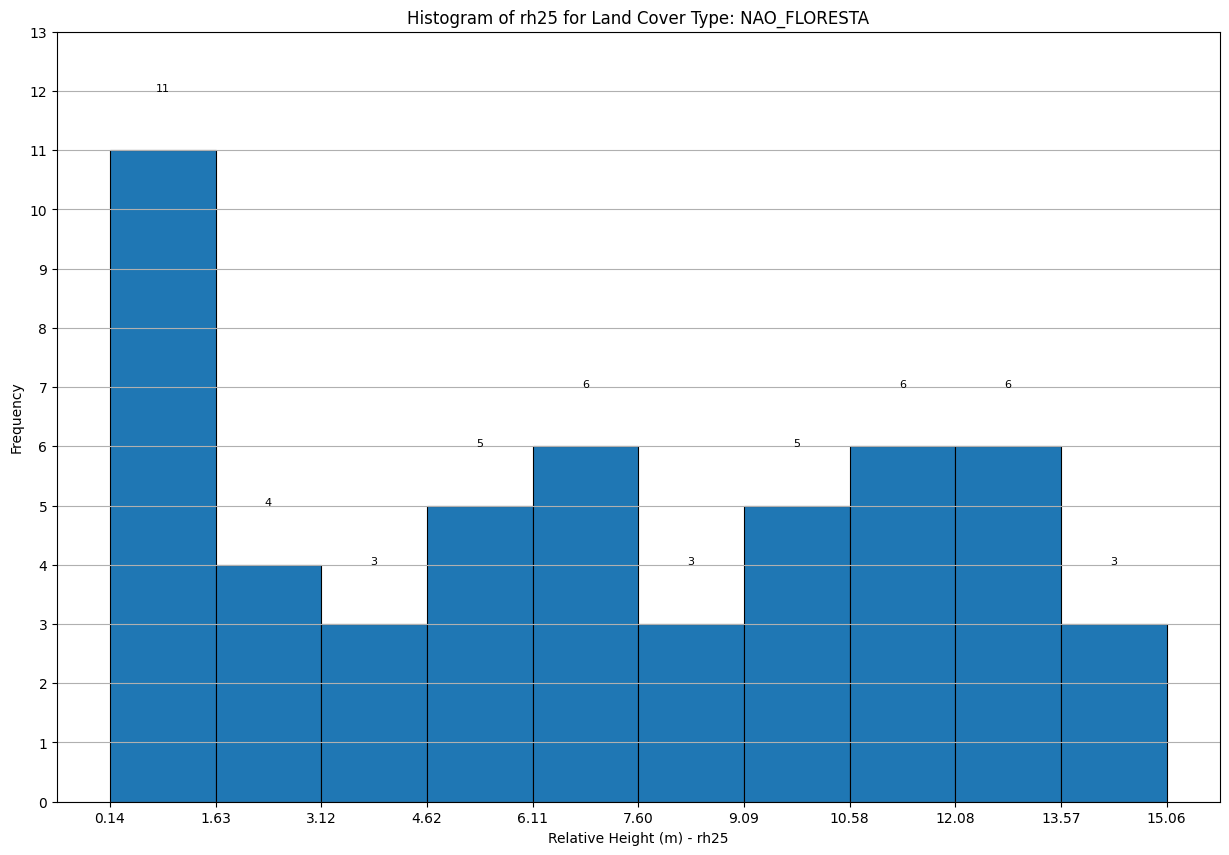

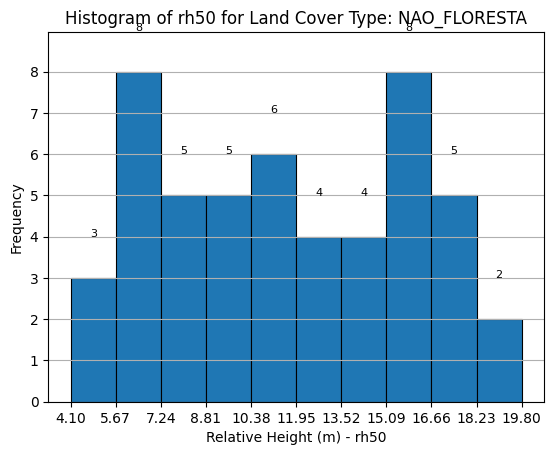

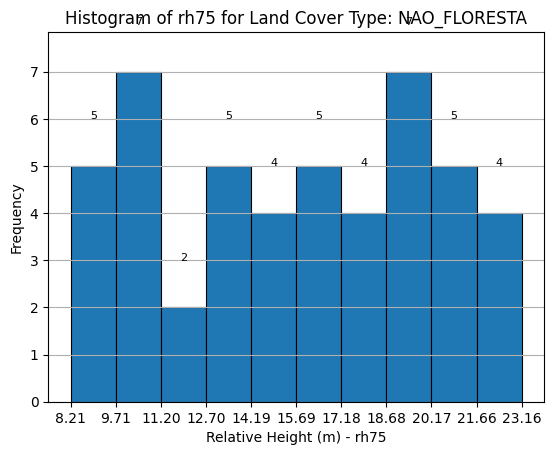

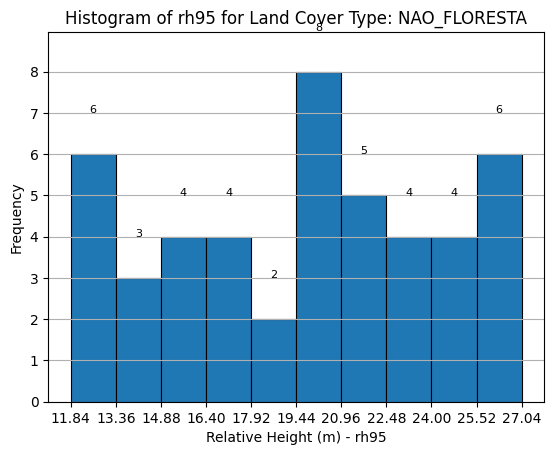

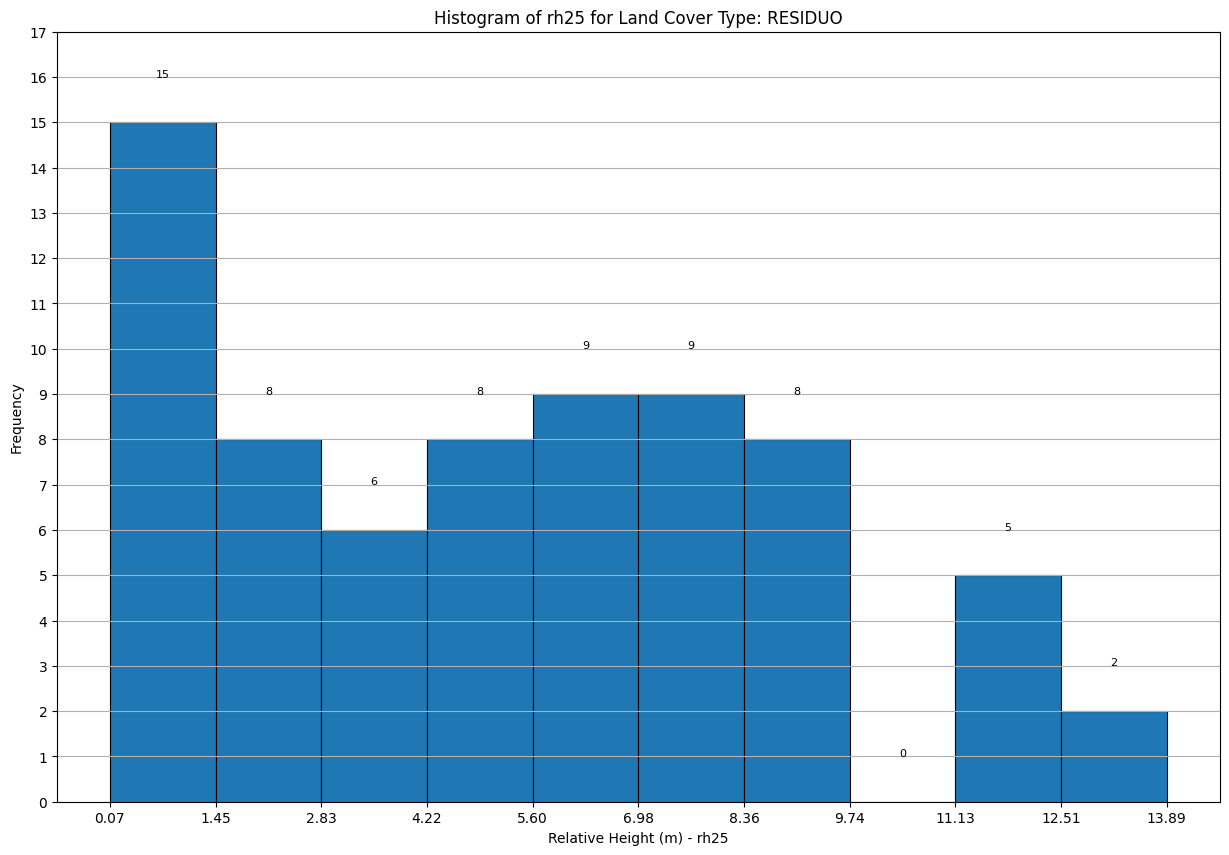

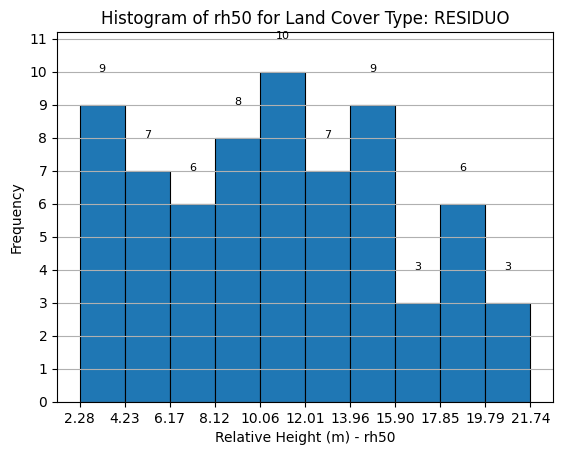

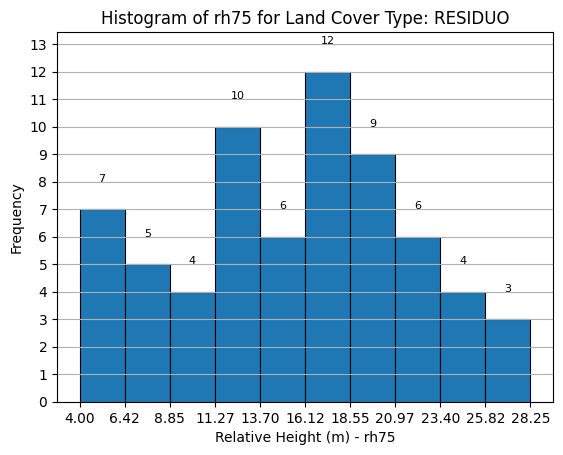

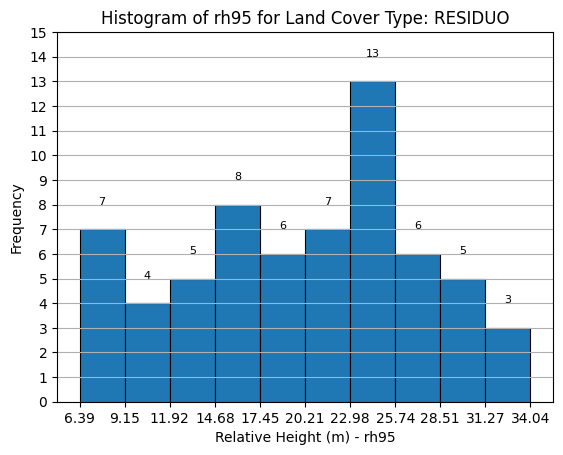

In [ ]:
# Create histograms based on different RH values 
land_types = matched_gdf['main_class'].unique()

for land_type in land_types:
    hist_data = matched_gdf[matched_gdf['main_class'] == land_type]
    rh_cols = [col for col in matched_gdf.columns if col.startswith('rh')]
    
    plt.figure(figsize=(15, 10))
    for rh_col in rh_cols:
        upper_outlier = hist_data[rh_col].dropna().quantile(0.99)
        hist_data = hist_data[hist_data[rh_col] <= upper_outlier] # remove upper 1% outliers
        lower_outlier = hist_data[rh_col].dropna().quantile(0.01)
        hist_data = hist_data[hist_data[rh_col] >= lower_outlier] # remove lower 1% outliers
        hist_data = hist_data[hist_data[rh_col] > 0] # remove negative values
        
        counts, bins, patches = plt.hist(x = hist_data[rh_col].dropna(), edgecolor='black', linewidth=0.8)  

        max_count = counts.max() if len(counts) else 0
        plt.ylim(0, max(plt.ylim()[1], max_count * 1.12))  # add room for labels
        
        # list counts at top of each bar if there are more than 5 bars
        if len(patches) > 5:
            for i in range(len(patches)):
                plt.text(bins[i] + (bins[i+1] - bins[i])/2, counts[i] + 1, str(int(counts[i])), ha='center', fontsize = 8)

        plt.title(f'Histogram of {rh_col} for Land Cover Type: {land_type}')
        plt.xlabel(f'Relative Height (m) - {rh_col}')
        plt.ylabel('Frequency')

        # dynamically add y ticks for readability
        locs, labels = plt.yticks()
        plt.yticks(np.arange(0, max(locs), step=max(1, int(max(locs)/10))))

        plt.xticks(bins)

        plt.grid(True) 
        plt.grid(axis='x')

        plt.show()